# Multi-language programming

In this lecture, we cover how to build packages involving multiple languages, how to compile a Python package into C and vice versa with Cython, and how to translate Python code into differentiable code with JAX.

## Cython

### What is Cython?

[Cython](https://docs.cython.org/en/stable/index.html) (/ˈsaɪθɒn/) is a superset of the programming language Python, which allows developers to write Python code (with optional, C-inspired syntax extensions) that yields performance comparable to that of C. Cython works by producing a standard Python module. However, the behavior differs from standard Python in that the module code, originally written in Python, is translated into C. ([Wikipedia](https://en.wikipedia.org/wiki/Cython))

Most research computing packages include Cython code, for instance scipy, numpy, pandas, scikit-learn, etc.

Typical Cython workflow includes:

- Convert Python code into Cython code
- Import C code into Cython code together with Python code
- Write Cython code inside Python code

When converting code into cython, we say we are **cythonizing** the code. In some cases, this can be done automatically in one line of code.


To use Cython, you first need to make sure it is installed. To install it, do:


In [2]:
!pip install Cython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.4 MB/s eta 0:00:00


### Cython magic

In a jupyter notebook, we can use the `%%cython` magic to write Cython code.

Beforehand, we load the extension. 

In [1]:
%load_ext Cython

Let us look at a simple example with a nested loop.


First, in Python:

In [2]:
def python_nested_loop(matrix):
    total = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            total += matrix[i][j]
    return total


In [3]:
import numpy as np
# Create a 2D matrix with size 1000x1000
matrix = [[i * j for j in range(1000)] for i in range(1000)]
matrix_np = np.array(matrix, dtype=np.int32)

In [4]:
%timeit -r 10 -n 10 python_nested_loop(matrix)

36.5 ms ± 543 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


Now in Cython:

In [5]:
%%cython
import numpy as np
cimport numpy as np

# Cython function to sum elements of a 2D matrix
def cython_nested_loop(np.ndarray[np.int32_t, ndim=2] matrix):
    cdef int total = 0
    cdef int i, j
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            total += matrix[i, j]
    return total


In [6]:
# Use timeit with -r and -n for the Cython implementation
%timeit -r 10 -n 10 cython_nested_loop(matrix_np)


1.15 ms ± 400 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


The Cython implementation is many times faster than the Python implementation (on a MacBook Pro M1 we get a 30x speedup).

The Cython nested loop is **faster** because of several reasons related to how Python and Cython handle variable types and execution:


**Static Typing in Cython:**

- **Python**: Variables are dynamically typed, so every operation (e.g., `total += matrix[i][j]`) requires:

  - Checking the types of `total`, `matrix[i]`, and `matrix[i][j]`.

  - Dynamically dispatching the appropriate operation based on those types.

- **Cython**: Variables are statically typed (e.g., `cdef int total, i, j`), meaning:

  - The types are known at compile time.

  - There’s no need for type checking or dynamic dispatch during execution.

  - The addition operation (`total += matrix[i, j]`) is compiled into efficient, low-level machine code.



**Avoiding Python Overhead:**

- **Python**: Every iteration of the loop involves Python’s internal overhead:

  - Reference counting and memory management for objects.

  - Function calls for accessing and operating on the matrix elements.

- **Cython**: The loops and operations are converted into C-level loops with no Python overhead. Accessing `matrix[i, j]` directly translates into efficient pointer arithmetic.


**Efficient Array Handling with NumPy in Cython:**

- **Python**: Even with NumPy, the indexing `matrix[i][j]` or `matrix[i, j]` involves:

  - A Python function call to NumPy's internal methods.

  - Boundary checks and type checks at runtime.

- **Cython**: Using `np.ndarray` with Cython avoids these Python-level calls:

  - Indexing operations (`matrix[i, j]`) are performed directly in C, bypassing Python entirely.

  - The `cimport`ed `numpy` module and static type declaration (e.g., `np.ndarray[np.int32_t, ndim=2]`) eliminate unnecessary checks.



**Compiler Optimizations:**

- Cython compiles the code into optimized C, enabling:

  - Loop unrolling: The compiler might optimize repetitive loop structures.

  - CPU-specific instructions: For example, SIMD operations when possible.

- Python’s interpreter cannot perform these low-level optimizations.

(Note: SIMD stands for Single Instruction, Multiple Data, a parallel computing paradigm used in processors to perform the same operation on multiple pieces of data simultaneously.)

**Reduced Function Call Overhead:**

In Python, every loop iteration may implicitly call functions to:

- Fetch the next index (`range(len(matrix))` involves dynamic object iteration).

- Access elements (`matrix[i][j]` involves Python’s `__getitem__` method).

Cython eliminates these function calls by working directly with compiled C loops and array pointers.


For a `1000 x 1000` matrix:

- **Python**: Each loop iteration involves thousands of type checks, boundary checks, and method calls. Even with a fast interpreter like CPython, this takes significant time.

- **Cython**: Executes the same nested loop in plain C, with just raw addition operations and pointer arithmetic.

This results in **an order-of-magnitude improvement in speed** with Cython.



**When Cython Does Not Help:**

If the task involves very high-level operations (e.g., NumPy's built-in vectorized functions like `np.sum()`), the advantage of using Cython is reduced because NumPy already performs these operations in optimized C.

However, for **nested loops** and tasks requiring manual iteration or array manipulation (e.g., matrices, vectors), Cython is vastly superior. 

### Cythonizing pure Python


It is easy to convert a pure Python package into Cython code. Let us give a working example with our [pygbm](https://github.com/borisbolliet/pygbm_package) package seen in the example class.

The core code consists of the following files:

```bash
pyproject.toml
pygbm
├── __init__.py
├── base_pygbm.py
└── gbm_simulation.py
```

To cythonize the package, follow the four following steps:

1. Move the python files into a `src/pygbm_x` folder.

2. Rename the `.py` files into `.pyx` files.

3. Modify the `pyproject.toml` file:

```toml
[build-system]
requires = ["setuptools", "Cython", "wheel"]
build-backend = "setuptools.build_meta"

[project]
name = "pygbm_x"
version = "0.0.1b2" # or whatever you want
description = "A package"

[tool.setuptools]
package-dir = {"" = "src"}
```

4. Add a `setup.py` file next to the `pyproject.toml` file, containing the following:


```python
from setuptools import setup, Extension
from Cython.Build import cythonize

# Define the extensions (Cython modules)
extensions = [
    Extension("pygbm_x.base_pygbm", ["src/pygbm_x/base_pygbm.pyx"]),
    Extension("pygbm_x.gbm_simulation", ["src/pygbm_x/gbm_simulation.pyx"]),
]

# Call setup with cythonized extensions
setup(
    ext_modules=cythonize(extensions,
    compiler_directives={'language_level': "3"}),
    package_dir={"": "src"},
    packages=["pygbm_x"],

    # # Include only .so/.pyd files (compiled extensions), exclude source files
    package_data={"pygbm_x": ["*.so", "*.pyd"]},
    exclude_package_data={"pygbm_x": ["*.pyx", "*.py"]},
    # Ensure that wheels can be built
    zip_safe=False,
)
```

To build the package we then do:

```bash
python setup.py build_ext --inplace
```

This builds the Cython code and create the `.so` and `.c` files, in the same folder as the `.pyx` files. The `.so` files are the compiled extensions (machine code) that can be imported in Python.

We then create the wheel with:

```bash
python setup.py bdist_wheel
```

which creates a `dist` folder with the wheel inside. Unlike for pure Python, the wheel now has the platform and specific Python version in the name.
It looks like:

```bash
pygbm_x-0.0.1b2-cp39-cp39-macosx_11_0_arm64.whl
``` 

The wheel can then be installed with:

```bash
pip install dist/pygbm_x-0.0.1b2-cp39-cp39-macosx_11_0_arm64.whl
```

And we can test the package.

In [1]:
import pygbm_x as pg

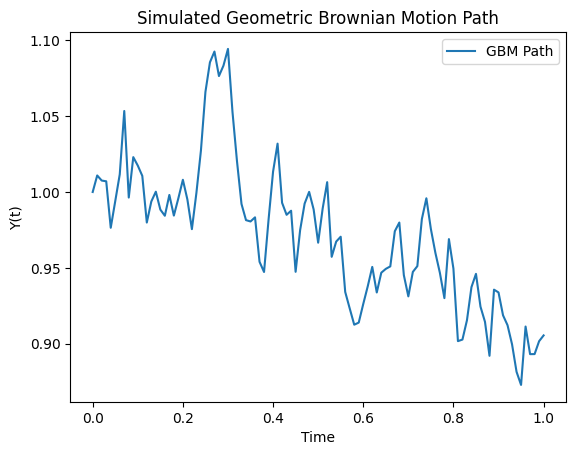

In [2]:
simulator = pg.GBMSimulator(y0=1.0, mu=0.05, sigma=0.2)
t_values, y_values = simulator.simulate_path(T=1.0, N=100)
simulator.plot_path(t_values, y_values)

### Creating wheels for multiple platforms

In this case, it becomes relevant to create wheels for multiple platforms. We use [cibuildwheel](https://cibuildwheel.readthedocs.io/en/stable/) to do this, it runs on Mac, Linux and Windows.

On Mac and Windows, it can run docker containers to build Linux wheels.

You can install it with:

```bash
pip install cibuildwheel
```

To build the wheel you can then do, from the root of the package:

```bash
CIBW_BUILD="cp311-manylinux_x86_64" CIBW_ARCHS="x86_64" cibuildwheel --platform linux
```

where you speficy the Python version and the architecture you want to build for. Note that for this to run on Mac/Windows, docker needs to run in the background (i.e., to be switched on).


This is an important part of continuous integration and this step would typically be run in a CI/CD pipeline (e.g. on Github Actions), see [here](https://cibuildwheel.pypa.io/en/stable/#usage) for more details.


On Mac, although your platform is ARM64, you can still build x86_64 wheels by switching your terminal to x86_64. To do so, navigate to the Applications/Utilities folder and click on Get Info on the Terminal application. A new window will open showing the application's properties. In the "Open using Rosetta" section, make sure "Open in Rosetta" is checked. You can then run the cibuildwheel command in the terminal.


### Turning C/C++ into Python

Cython can also be used to turn C/C++ libraries into Python packages. We won't cover an example of this here, but you can find more information [here](https://cython.readthedocs.io/en/stable/src/userguide/wrapping_CPlusPlus.html).

In the jargon, we say we are **wrapping** the C/C++ code into Python code. The C/C++ functions that we want to wrap are declared in a Cython header file (with `.pxd` extension), and defined in the Cython source file (with `.pyx` extension).

This is extremely useful because it means that you can use Python syntax to call C/C++ functions (generally much more optimised) without the overhead of calling a Python function. 

Notable examples where this is useful is for codes that rely on OpenMP parallelisation, or that use BLAS/LAPACK libraries. 

However, this procedure does not allow you to perform automatic differentiation easily. 






## Differentiable programming


Writing differentiable code is crucial for machine learning pipelines as it allows for efficient, machine-precision gradient computations. This is referred to as [**automatic differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation) and is based on the chain rule. 


PyTorch, TensorFlow and Jax provide differentiable programming frameworks available in Python, i.e., they can be imported in Python code. Julia is a separate language that is also differentiable.

We will look at a simple example in the four cases. 

Consider the function:

$$ f(a, x) = \frac{\sin(a x)}{x} $$


For $a=0.5$ and $x \in [-50, 50]$, this function looks like:

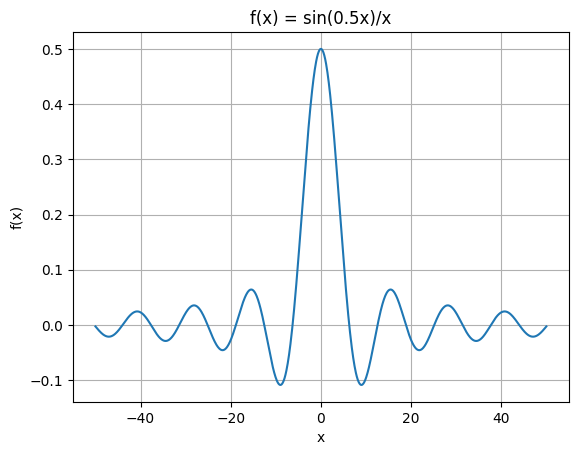

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values
x = np.linspace(-50, 50, 1000)
# Set a
a = 0.5

# Calculate f(x)
f = np.sin(a * x) / x

plt.figure()
plt.plot(x, f)
plt.grid(True)
plt.title(f'f(x) = sin({a}x)/x')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


### PyTorch

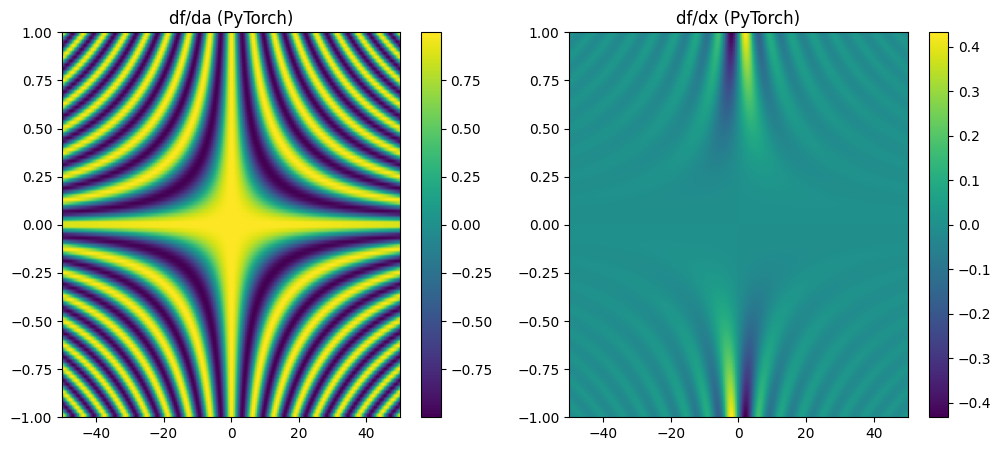

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def f(a, x):
    return torch.sin(a * x) / x

# Create grid for a and x
a = torch.linspace(-1, 1, 100, requires_grad=True)
x = torch.linspace(-50, 50, 200, requires_grad=True)
A, X = torch.meshgrid(a, x, indexing='ij')

# Compute the function
F = f(A, X)

# Compute derivatives
grad_a, grad_x = torch.autograd.grad(
    F.sum(), [A, X], create_graph=True # see https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/
)

# Plot the derivatives
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("df/da (PyTorch)")
plt.imshow(grad_a.detach().numpy(), extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("df/dx (PyTorch)")
plt.imshow(grad_x.detach().numpy(), extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.show()


### TensorFlow

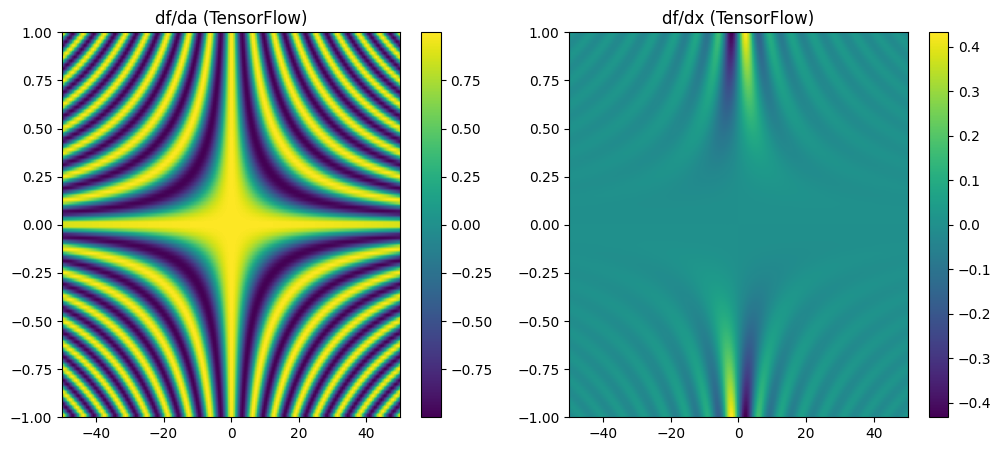

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the function
@tf.function
def f(a, x):
    return tf.sin(a * x) / x

# Create grid for a and x
a = tf.linspace(-1.0, 1.0, 100)
x = tf.linspace(-50.0, 50.0, 200)
A, X = tf.meshgrid(a, x, indexing='ij')

with tf.GradientTape() as tape_a, tf.GradientTape() as tape_x:
    tape_a.watch(A)
    tape_x.watch(X)
    F = f(A, X)

grad_a = tape_a.gradient(F, A)
grad_x = tape_x.gradient(F, X)

# Plot the derivatives
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("df/da (TensorFlow)")
plt.imshow(grad_a.numpy(), extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("df/dx (TensorFlow)")
plt.imshow(grad_x.numpy(), extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.show()


### Jax

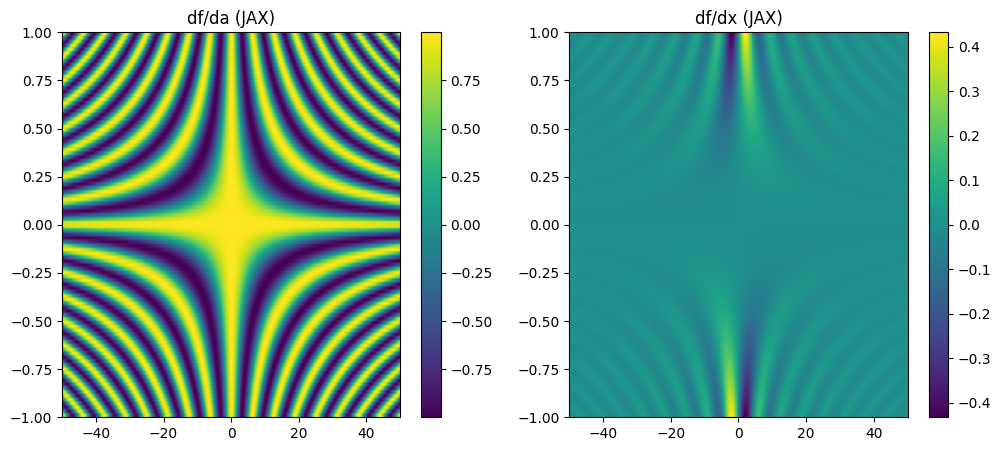

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define the function
def f(a, x):
    return jnp.sin(a * x) / x

# Create grid for a and x
a = jnp.linspace(-1.0, 1.0, 100)
x = jnp.linspace(-50.0, 50.0, 200)
A, X = jnp.meshgrid(a, x, indexing='ij')

# Compute derivatives
df_da = jax.grad(lambda a, x: f(a, x).sum(), argnums=0)(A, X)
df_dx = jax.grad(lambda a, x: f(a, x).sum(), argnums=1)(A, X)

# Plot the derivatives
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("df/da (JAX)")
plt.imshow(df_da, extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("df/dx (JAX)")
plt.imshow(df_dx, extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.show()


### Julia

In [1]:
println("Hello")

Hello


In [2]:
using Pkg
Pkg.add("IJulia")
Pkg.add("Zygote")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


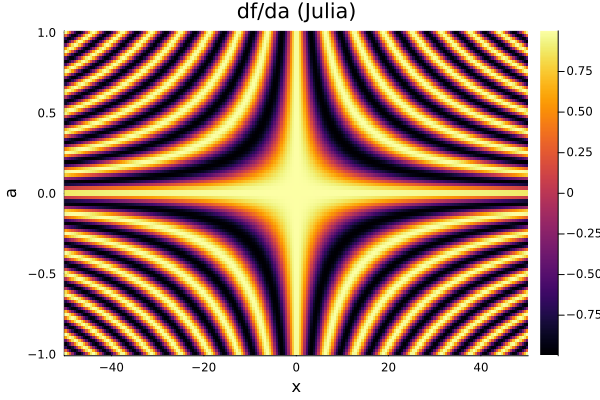

In [3]:
using Zygote, Plots

# Define the function
f(a, x) = x == 0 ? a : sin(a * x) / x  # Handle division by zero

# Create grid for a and x
a = LinRange(-1, 1, 100)  # 100 points between -1 and 1
x = LinRange(-50, 50, 200)  # 200 points between -50 and 50

# Compute derivatives
df_da = [gradient(a -> f(a, x), a)[1] for a in a, x in x]  # Gradient w.r.t. `a`
df_dx = [gradient(x -> f(a, x), x)[1] for a in a, x in x]  # Gradient w.r.t. `x`

# Plot the derivatives
heatmap(x, a, df_da, title="df/da (Julia)", xlabel="x", ylabel="a", colorbar=true)



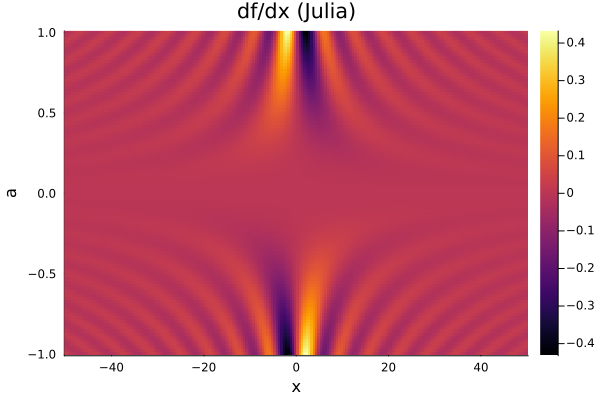

In [4]:
heatmap(x, a, df_dx, title="df/dx (Julia)", xlabel="x", ylabel="a", colorbar=true)